# Table Extraction

Extracting tables from PDFs can range from straightforward to complex. Natural PDF provides several tools and methods to handle different scenarios, leveraging both rule-based (`pdfplumber`) and model-based (`TATR`) approaches.

## Setup

Let's load a PDF containing tables.

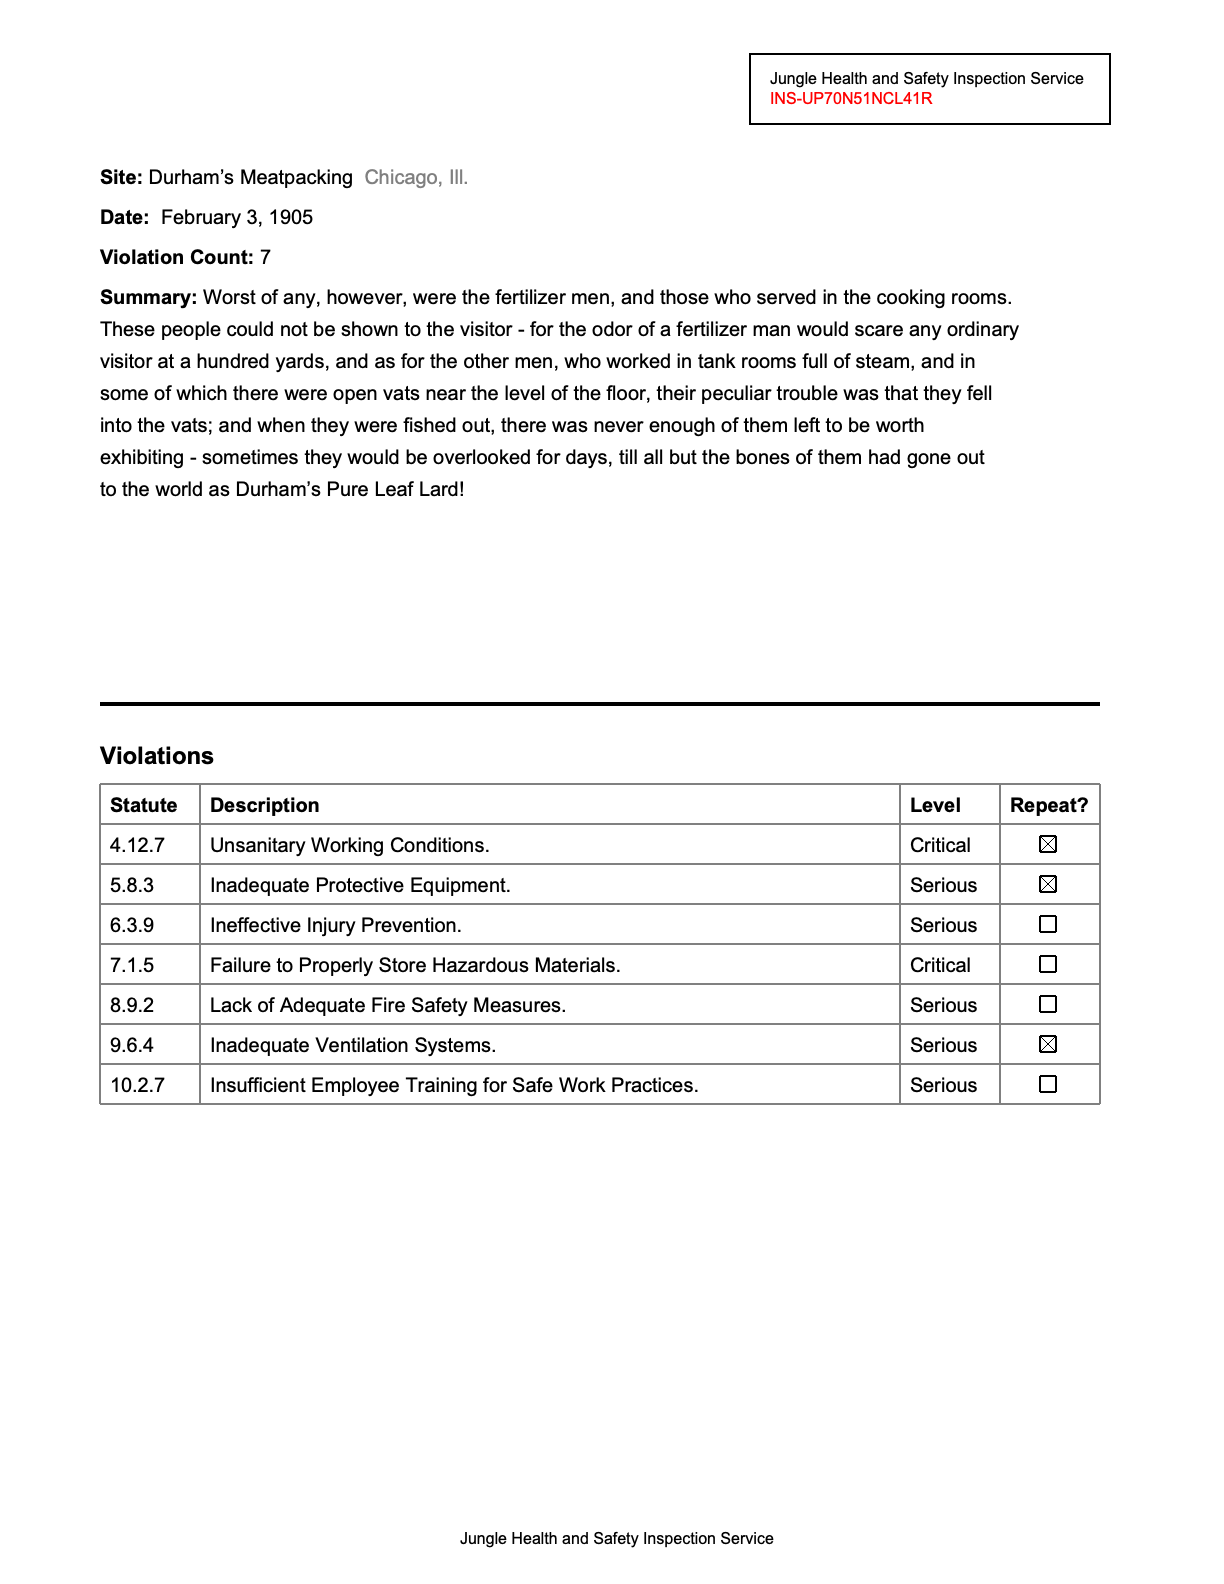

In [1]:
from natural_pdf import PDF

# Load the PDF
pdf = PDF("https://github.com/jsoma/natural-pdf/raw/refs/heads/main/pdfs/01-practice.pdf")

# Select the first page
page = pdf.pages[0]

# Display the page
page.show()

## Basic Table Extraction (No Detection)

If you know a table exists, you can try `extract_table()` directly on the page or a region. This uses `pdfplumber` behind the scenes.

In [2]:
# Extract the first table found on the page using pdfplumber
# This works best for simple tables with clear lines
table_data = page.extract_table() # Returns a list of lists
table_data

[['Statute', 'Description', 'Level', 'Repeat?'],
 ['4.12.7', 'Unsanitary Working Conditions.', 'Critical', ''],
 ['5.8.3', 'Inadequate Protective Equipment.', 'Serious', ''],
 ['6.3.9', 'Ineffective Injury Prevention.', 'Serious', ''],
 ['7.1.5', 'Failure to Properly Store Hazardous Materials.', 'Critical', ''],
 ['8.9.2', 'Lack of Adequate Fire Safety Measures.', 'Serious', ''],
 ['9.6.4', 'Inadequate Ventilation Systems.', 'Serious', ''],
 ['10.2.7',
  'Insufficient Employee Training for Safe Work Practices.',
  'Serious',
  '']]

*This might fail or give poor results if there are multiple tables or the table structure is complex.*

## Layout Analysis for Table Detection

A more robust approach can be to first *detect* the table boundaries using layout analysis.

### Using YOLO (Default)

The default YOLO model finds the overall bounding box of tables.

image 1/1 /var/folders/25/h3prywj14qb0mlkl2s8bxq5m0000gn/T/tmptrpq_4cf/temp_layout_image.png: 1024x800 2 titles, 3 plain texts, 2 abandons, 1 table, 2941.3ms


Speed: 7.3ms preprocess, 2941.3ms inference, 0.9ms postprocess per image at shape (1, 3, 1024, 800)


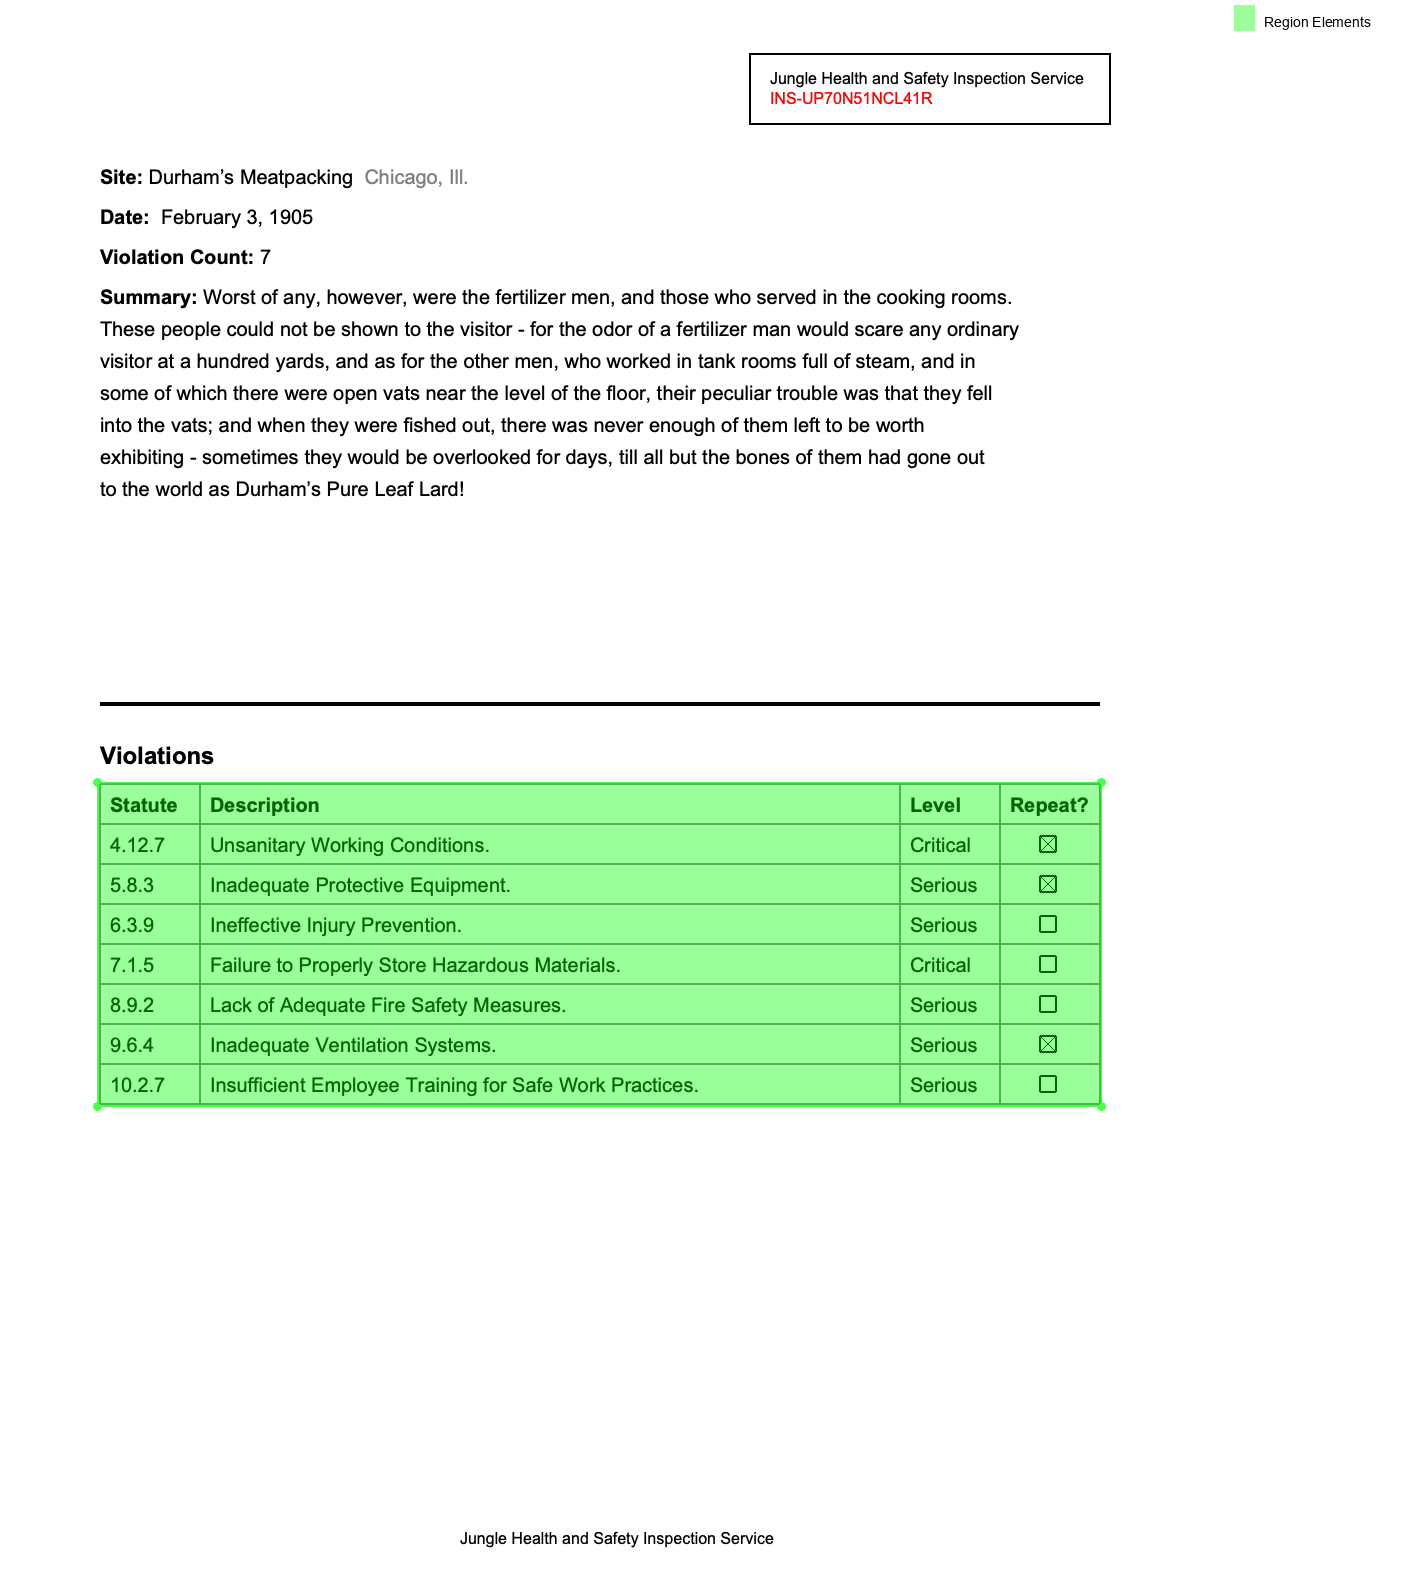

In [3]:
# Detect layout elements using YOLO (default)
page.analyze_layout(engine='yolo')

# Find regions detected as tables
table_regions_yolo = page.find_all('region[type=table][model=yolo]')
table_regions_yolo.show()

In [4]:
table_regions_yolo[0].extract_table()

[['Statute', 'Description', 'Level', 'Repeat?'],
 ['4.12.7', 'Unsanitary Working Conditions.', 'Critical', ''],
 ['5.8.3', 'Inadequate Protective Equipment.', 'Serious', ''],
 ['6.3.9', 'Ineffective Injury Prevention.', 'Serious', ''],
 ['7.1.5', 'Failure to Properly Store Hazardous Materials.', 'Critical', ''],
 ['8.9.2', 'Lack of Adequate Fire Safety Measures.', 'Serious', ''],
 ['9.6.4', 'Inadequate Ventilation Systems.', 'Serious', ''],
 ['10.2.7',
  'Insufficient Employee Training for Safe Work Practices.',
  'Serious',
  '']]

### Using TATR (Table Transformer)

The TATR model provides detailed table structure (rows, columns, headers).

In [5]:
page.clear_detected_layout_regions() # Clear previous YOLO regions for clarity
page.analyze_layout(engine='tatr')

<ElementCollection[Region](count=15)>

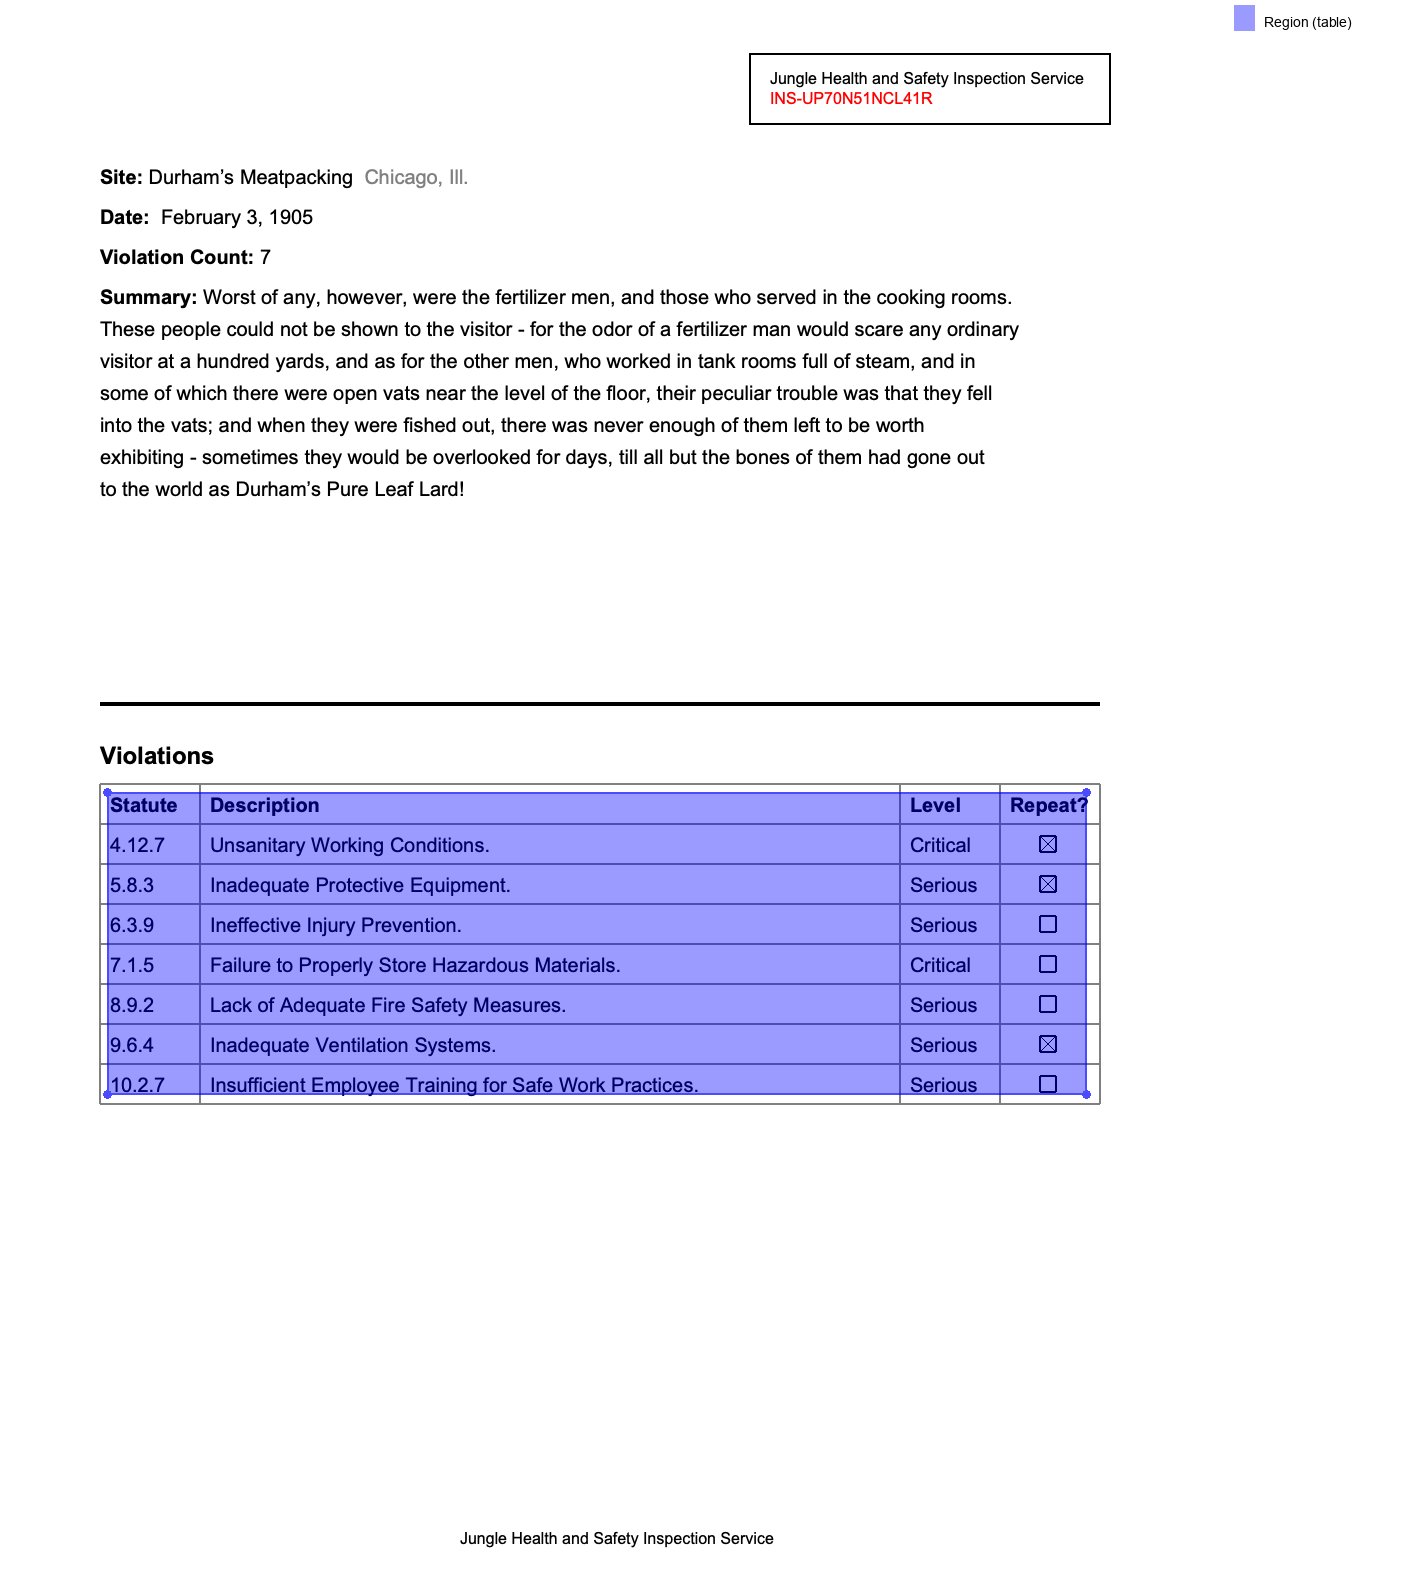

In [6]:
# Find the main table region(s) detected by TATR
tatr_table = page.find('region[type=table][model=tatr]')
tatr_table.show()

In [7]:
# Find rows, columns, headers detected by TATR
rows = page.find_all('region[type=table-row][model=tatr]')
cols = page.find_all('region[type=table-column][model=tatr]')
hdrs = page.find_all('region[type=table-column-header][model=tatr]')
f"TATR found: {len(rows)} rows, {len(cols)} columns, {len(hdrs)} headers"

'TATR found: 8 rows, 4 columns, 1 headers'

## Controlling Extraction Method (`plumber` vs `tatr`)

When you call `extract_table()` on a region:
- If the region was detected by **YOLO** (or not detected at all), it uses the `plumber` method.
- If the region was detected by **TATR**, it defaults to the `tatr` method, which uses the detected row/column structure.

You can override this using the `method` argument.

In [8]:
tatr_table = page.find('region[type=table][model=tatr]')
tatr_table.extract_table(method='tatr')

[['Statute Description Level Repeat?'],
 ['Statute', 'Description', 'Level', 'Repeat?'],
 ['4.12.7', 'Unsanitary Working Conditions.', 'Critical', ''],
 ['5.8.3', 'Inadequate Protective Equipment.', 'Serious', ''],
 ['6.3.9', 'Ineffective Injury Prevention.', 'Serious', ''],
 ['7.1.5', 'Failure to Properly Store Hazardous Materials.', 'Critical', ''],
 ['8.9.2', 'Lack of Adequate Fire Safety Measures.', 'Serious', ''],
 ['9.6.4', 'Inadequate Ventilation Systems.', 'Serious', ''],
 ['10.2.7',
  'Insufficient Employee Training for Safe Work Practices.',
  'Serious',
  '']]

In [9]:
# Force using pdfplumber even on a TATR-detected region
# (Might be useful for comparison or if TATR structure is flawed)
tatr_table = page.find('region[type=table][model=tatr]')
tatr_table.extract_table(method='pdfplumber')

[['Unsanitary Working Conditions.', 'Critical'],
 ['Inadequate Protective Equipment.', 'Serious'],
 ['Ineffective Injury Prevention.', 'Serious'],
 ['Failure to Properly Store Hazardous Materials.', 'Critical'],
 ['Lack of Adequate Fire Safety Measures.', 'Serious'],
 ['Inadequate Ventilation Systems.', 'Serious']]

### When to Use Which Method?

- **`pdfplumber`**: Good for simple tables with clear grid lines. Faster.
- **`tatr`**: Better for tables without clear lines, complex cell merging, or irregular layouts. Leverages the model's understanding of rows and columns.

## Customizing `pdfplumber` Settings

If using the `pdfplumber` method (explicitly or implicitly), you can pass `pdfplumber` settings via `table_settings`.

In [10]:
# Example: Use text alignment for vertical lines, explicit lines for horizontal
# See pdfplumber documentation for all settings
table_settings = {
    "vertical_strategy": "text",
    "horizontal_strategy": "lines",
    "intersection_x_tolerance": 5, # Increase tolerance for intersections
}

results = page.extract_table(
    table_settings=table_settings
)

## Saving Extracted Tables

You can easily save the extracted data (list of lists) to common formats.

In [11]:
import pandas as pd

pd.DataFrame(page.extract_table())

,0,1,2,3
0,Statute,Description,Level,Repeat?
1,4.12.7,Unsanitary Working Conditions.,Critical,
2,5.8.3,Inadequate Protective Equipment.,Serious,
3,6.3.9,Ineffective Injury Prevention.,Serious,
4,7.1.5,Failure to Properly Store Hazardous Materials.,Critical,
5,8.9.2,Lack of Adequate Fire Safety Measures.,Serious,
6,9.6.4,Inadequate Ventilation Systems.,Serious,
7,10.2.7,Insufficient Employee Training for Safe Work P...,Serious,


## Working Directly with TATR Cells

The TATR engine implicitly creates cell regions at the intersection of detected rows and columns. You can access these for fine-grained control.

In [12]:
# This doesn't work! I forget why, I should troubleshoot later.
# tatr_table.cells

## Next Steps

- [Layout Analysis](../layout-analysis/index.ipynb): Understand how table detection fits into overall document structure analysis.
- [Working with Regions](../regions/index.ipynb): Manually define table areas if detection fails.